In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.io import arff
import warnings
warnings.filterwarnings('ignore')
import os

os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/results', exist_ok=True)
os.makedirs('outputs/gridsearch', exist_ok=True)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 1. Load and Preprocess Data

In [2]:
# Load CKD data from ARFF file with custom parsing
import re

# Read the ARFF file
with open('kidney_disease/chronic_kidney_disease_full.arff', 'r') as f:
    content = f.read()

# Extract column names from @attribute lines
attributes = []
for line in content.split('\n'):
    if line.startswith('@attribute'):
        match = re.search(r"@attribute\s+'?(\w+)'?", line)
        if match:
            attributes.append(match.group(1))

# Extract data section
data_section = content.split('@data')[1].strip()

# Parse data lines
data_rows = []
for line in data_section.split('\n'):
    if line.strip():
        # Split by comma and strip whitespace from each value
        values = [v.strip() for v in line.split(',')]
        # Only keep lines with correct number of columns
        if len(values) == len(attributes):
            data_rows.append(values)

# Create DataFrame
df = pd.DataFrame(data_rows, columns=attributes)

# Replace '?' with NaN
df = df.replace('?', np.nan)

# Convert numeric columns
numeric_cols_to_convert = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
for col in numeric_cols_to_convert:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['class'].value_counts())
print(f"\nMissing values per column:")
print(df.isnull().sum())

# Encode target variable (Binary: 0 = notckd, 1 = ckd)
df['class'] = df['class'].map({'notckd': 0, 'ckd': 1})

# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target from numeric cols if present
if 'class' in numeric_cols:
    numeric_cols.remove('class')

# Impute missing values
# Numeric: median
if numeric_cols:
    imputer_num = SimpleImputer(strategy='median')
    df[numeric_cols] = imputer_num.fit_transform(df[numeric_cols])

# Categorical: most frequent
if categorical_cols:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Split features and target
X = df.drop('class', axis=1)
y = df['class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Data preprocessed")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution - Train: {np.bincount(y_train.astype(int))}")
print(f"Class distribution - Test: {np.bincount(y_test.astype(int))}")

Dataset shape: (397, 25)

Target distribution:
class
ckd       248
notckd    149
Name: count, dtype: int64

Missing values per column:
age        9
bp        12
sg        47
al        46
su        49
rbc      150
pc        65
pcc        4
ba         4
bgr       43
bu        19
sc        17
sod       85
pot       86
hemo      52
pcv       70
wbcc     105
rbcc     130
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

✓ Data preprocessed
Training set: (277, 24)
Test set: (120, 24)
Class distribution - Train: [104 173]
Class distribution - Test: [45 75]


## 2. Define Hyperparameter Grids

In [3]:
# Define hyperparameter grids (same as Census for consistency)
param_grids = {
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
    },
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (150, 100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [500]
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'criterion': ['gini', 'entropy']
    },
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
    }
}

classifiers = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42),
    'MLP': MLPClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

print("✓ Hyperparameter grids defined")
print(f"\nTotal classifiers: {len(classifiers)}")
for name, grid in param_grids.items():
    total_combinations = np.prod([len(v) for v in grid.values()])
    print(f"{name}: {len(grid)} hyperparameters, {total_combinations} combinations")

✓ Hyperparameter grids defined

Total classifiers: 6
KNN: 3 hyperparameters, 28 combinations
Logistic Regression: 4 hyperparameters, 24 combinations
SVM: 3 hyperparameters, 60 combinations
MLP: 5 hyperparameters, 60 combinations
Decision Tree: 4 hyperparameters, 224 combinations
Naive Bayes: 1 hyperparameters, 7 combinations


## 3. Perform GridSearchCV

In [4]:
grid_results = {}
best_models = {}

print("="*80)
print("CHRONIC KIDNEY DISEASE - HYPERPARAMETER SENSITIVITY ANALYSIS")
print("="*80)

for name in classifiers.keys():
    print(f"\n{'='*80}")
    print(f"GridSearchCV: {name}")
    print(f"{'='*80}")
    
    clf = classifiers[name]
    param_grid = param_grids[name]
    
    grid_search = GridSearchCV(
        clf, 
        param_grid, 
        cv=3, 
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    grid_results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_results': grid_search.cv_results_,
        'all_scores': grid_search.cv_results_['mean_test_score'],
        'std_scores': grid_search.cv_results_['std_test_score']
    }
    best_models[name] = grid_search.best_estimator_
    
    y_pred = grid_search.best_estimator_.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    
    score_variance = np.var(grid_search.cv_results_['mean_test_score'])
    score_std = np.std(grid_search.cv_results_['mean_test_score'])
    score_range = np.max(grid_search.cv_results_['mean_test_score']) - np.min(grid_search.cv_results_['mean_test_score'])
    
    grid_results[name]['test_accuracy'] = test_accuracy
    grid_results[name]['test_f1'] = test_f1
    grid_results[name]['variance'] = score_variance
    grid_results[name]['std'] = score_std
    grid_results[name]['range'] = score_range
    
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")
    print(f"\nHyperparameter Sensitivity:")
    print(f"  Variance: {score_variance:.6f}")
    print(f"  Std Dev: {score_std:.6f}")
    print(f"  Range: {score_range:.4f}")
    print(f"\nBest Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")

print(f"\n{'='*80}")
print("✓ GridSearchCV completed")
print(f"{'='*80}")

CHRONIC KIDNEY DISEASE - HYPERPARAMETER SENSITIVITY ANALYSIS

GridSearchCV: KNN
Best CV Score: 0.9676
Test Accuracy: 0.9333
Test F1-Score: 0.9437

Hyperparameter Sensitivity:
  Variance: 0.000821
  Std Dev: 0.028656
  Range: 0.1010

Best Parameters:
  metric: euclidean
  n_neighbors: 3
  weights: uniform

GridSearchCV: Logistic Regression
Best CV Score: 0.9676
Test Accuracy: 0.9333
Test F1-Score: 0.9437

Hyperparameter Sensitivity:
  Variance: 0.000821
  Std Dev: 0.028656
  Range: 0.1010

Best Parameters:
  metric: euclidean
  n_neighbors: 3
  weights: uniform

GridSearchCV: Logistic Regression
Best CV Score: 0.9964
Test Accuracy: 0.9917
Test F1-Score: 0.9933

Hyperparameter Sensitivity:
  Variance: 0.037188
  Std Dev: 0.192842
  Range: 0.6210

Best Parameters:
  C: 1
  max_iter: 1000
  penalty: l1
  solver: saga

GridSearchCV: SVM
Best CV Score: 0.9964
Test Accuracy: 0.9750
Test F1-Score: 0.9796

Hyperparameter Sensitivity:
  Variance: 0.018250
  Std Dev: 0.135094
  Range: 0.3719

Bes

## 4. Sensitivity Summary

In [5]:
sensitivity_summary = pd.DataFrame({
    'Classifier': list(grid_results.keys()),
    'Best CV Score': [grid_results[name]['best_score'] for name in grid_results.keys()],
    'Test Accuracy': [grid_results[name]['test_accuracy'] for name in grid_results.keys()],
    'Test F1': [grid_results[name]['test_f1'] for name in grid_results.keys()],
    'Variance': [grid_results[name]['variance'] for name in grid_results.keys()],
    'Std Dev': [grid_results[name]['std'] for name in grid_results.keys()],
    'Range': [grid_results[name]['range'] for name in grid_results.keys()]
})

sensitivity_summary = sensitivity_summary.round(4)
sensitivity_summary = sensitivity_summary.sort_values('Variance', ascending=False)

print("\n" + "="*80)
print("HYPERPARAMETER SENSITIVITY RANKING - CHRONIC KIDNEY DISEASE")
print("="*80)
print(sensitivity_summary.to_string(index=False))

sensitivity_summary.to_csv('outputs/results/ckd_sensitivity.csv', index=False)
print("\n✓ Results saved to: outputs/results/ckd_sensitivity.csv")

most_sensitive = sensitivity_summary.iloc[0]['Classifier']
least_sensitive = sensitivity_summary.iloc[-1]['Classifier']
print(f"\nMost Sensitive: {most_sensitive}")
print(f"Least Sensitive: {least_sensitive}")


HYPERPARAMETER SENSITIVITY RANKING - CHRONIC KIDNEY DISEASE
         Classifier  Best CV Score  Test Accuracy  Test F1  Variance  Std Dev  Range
Logistic Regression         0.9964         0.9917   0.9933    0.0372   0.1928 0.6210
                SVM         0.9964         0.9750   0.9796    0.0183   0.1351 0.3719
                KNN         0.9676         0.9333   0.9437    0.0008   0.0287 0.1010
      Decision Tree         0.9676         0.9917   0.9933    0.0001   0.0113 0.0507
                MLP         0.9964         0.9833   0.9865    0.0000   0.0030 0.0072
        Naive Bayes         0.9747         0.9417   0.9510    0.0000   0.0000 0.0000

✓ Results saved to: outputs/results/ckd_sensitivity.csv

Most Sensitive: Logistic Regression
Least Sensitive: Naive Bayes


## 5. Visualizations

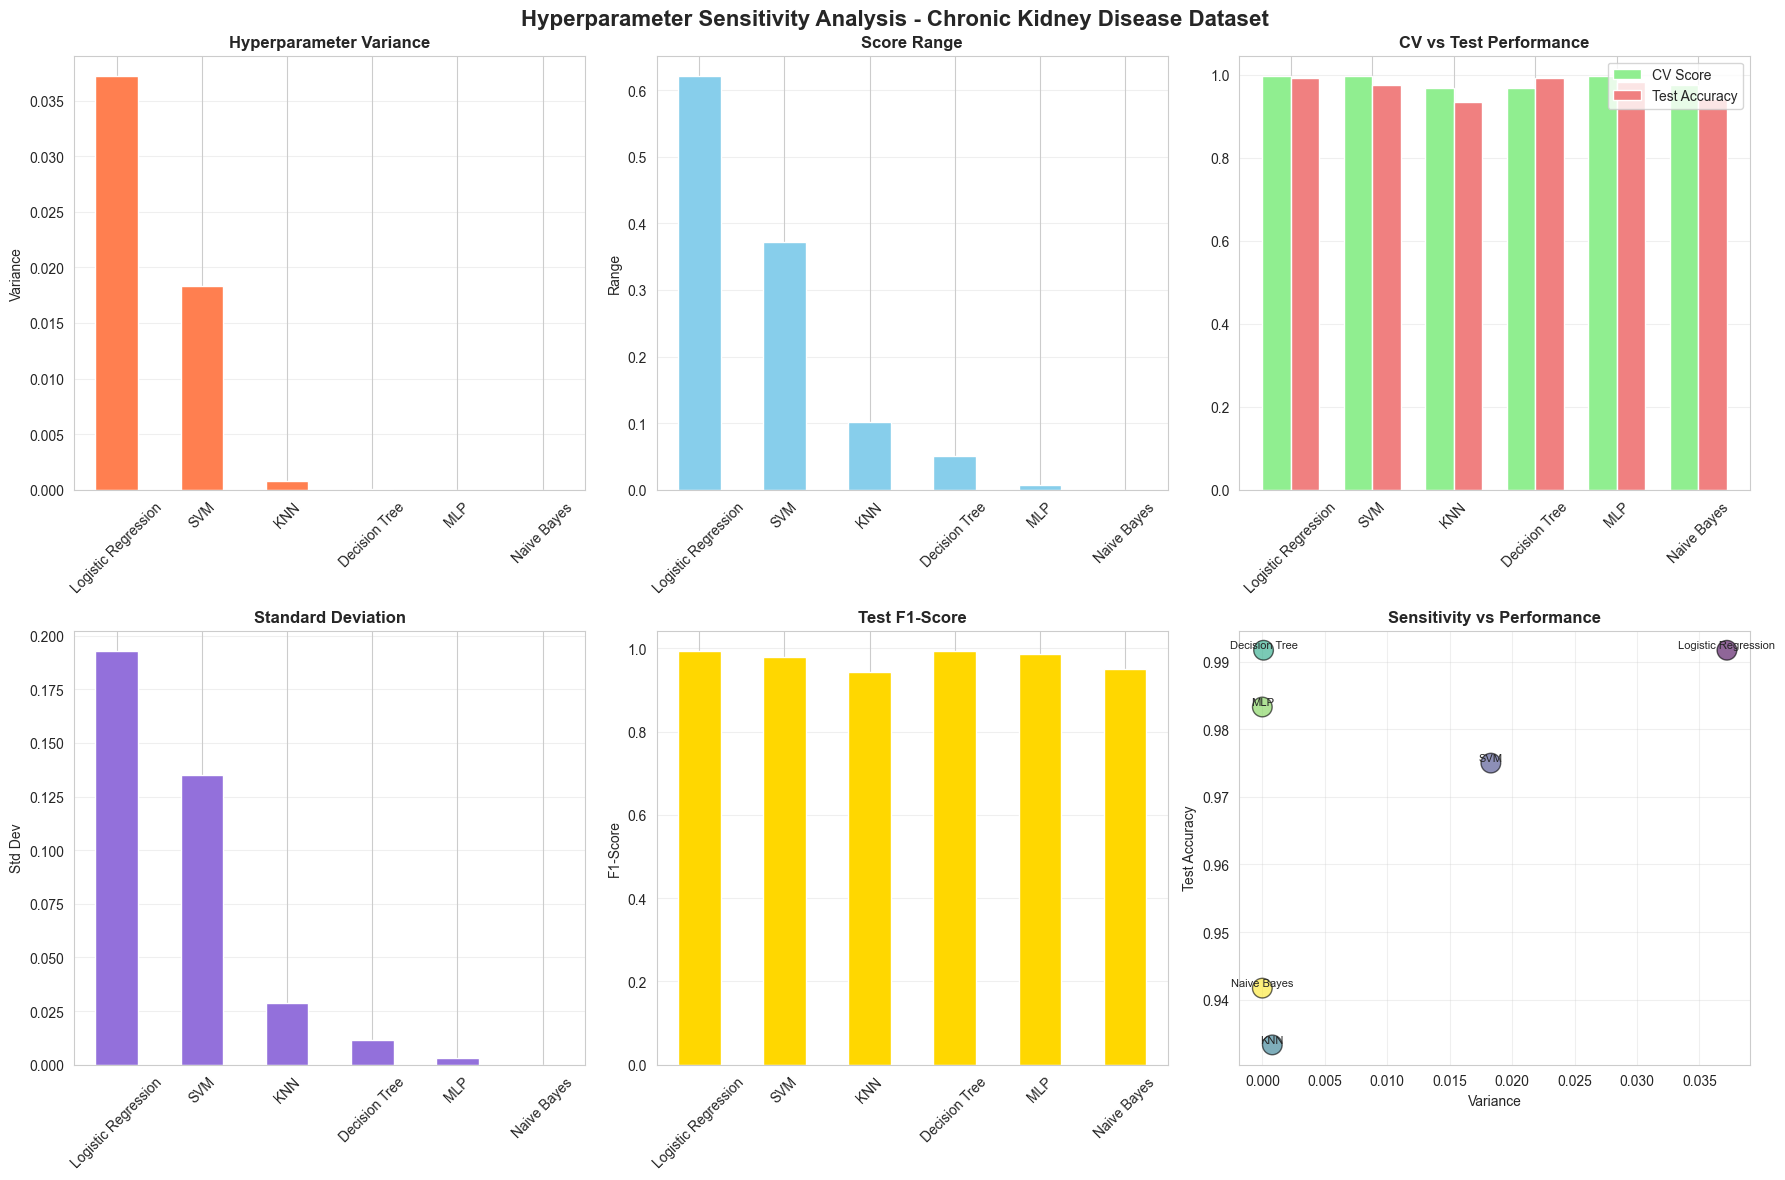

✓ Visualizations saved


In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Hyperparameter Sensitivity Analysis - Chronic Kidney Disease Dataset', fontsize=16, fontweight='bold')

ax = axes[0, 0]
sensitivity_summary.plot(x='Classifier', y='Variance', kind='bar', ax=ax, color='coral', legend=False)
ax.set_title('Hyperparameter Variance', fontweight='bold')
ax.set_ylabel('Variance')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

ax = axes[0, 1]
sensitivity_summary.plot(x='Classifier', y='Range', kind='bar', ax=ax, color='skyblue', legend=False)
ax.set_title('Score Range', fontweight='bold')
ax.set_ylabel('Range')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

ax = axes[0, 2]
x_pos = np.arange(len(sensitivity_summary))
width = 0.35
ax.bar(x_pos - width/2, sensitivity_summary['Best CV Score'], width, label='CV Score', color='lightgreen')
ax.bar(x_pos + width/2, sensitivity_summary['Test Accuracy'], width, label='Test Accuracy', color='lightcoral')
ax.set_title('CV vs Test Performance', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(sensitivity_summary['Classifier'], rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

ax = axes[1, 0]
sensitivity_summary.plot(x='Classifier', y='Std Dev', kind='bar', ax=ax, color='mediumpurple', legend=False)
ax.set_title('Standard Deviation', fontweight='bold')
ax.set_ylabel('Std Dev')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

ax = axes[1, 1]
sensitivity_summary.plot(x='Classifier', y='Test F1', kind='bar', ax=ax, color='gold', legend=False)
ax.set_title('Test F1-Score', fontweight='bold')
ax.set_ylabel('F1-Score')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

ax = axes[1, 2]
scatter = ax.scatter(sensitivity_summary['Variance'], sensitivity_summary['Test Accuracy'], 
                     s=200, c=range(len(sensitivity_summary)), cmap='viridis', alpha=0.6, edgecolors='black')
for idx, row in sensitivity_summary.iterrows():
    ax.annotate(row['Classifier'], (row['Variance'], row['Test Accuracy']), fontsize=8, ha='center', va='bottom')
ax.set_title('Sensitivity vs Performance', fontweight='bold')
ax.set_xlabel('Variance')
ax.set_ylabel('Test Accuracy')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/figures/ckd_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved")

## 6. Save Detailed Results

In [7]:
for name in grid_results.keys():
    cv_results = grid_results[name]['cv_results']
    results_df = pd.DataFrame(cv_results)
    results_df.to_csv(f'outputs/gridsearch/ckd_{name.replace(" ", "_").lower()}_gridsearch.csv', index=False)

print("✓ Detailed GridSearch results saved to outputs/gridsearch/")
print("\n" + "="*80)
print("✓ Analysis complete for Chronic Kidney Disease dataset")
print("="*80)

✓ Detailed GridSearch results saved to outputs/gridsearch/

✓ Analysis complete for Chronic Kidney Disease dataset
